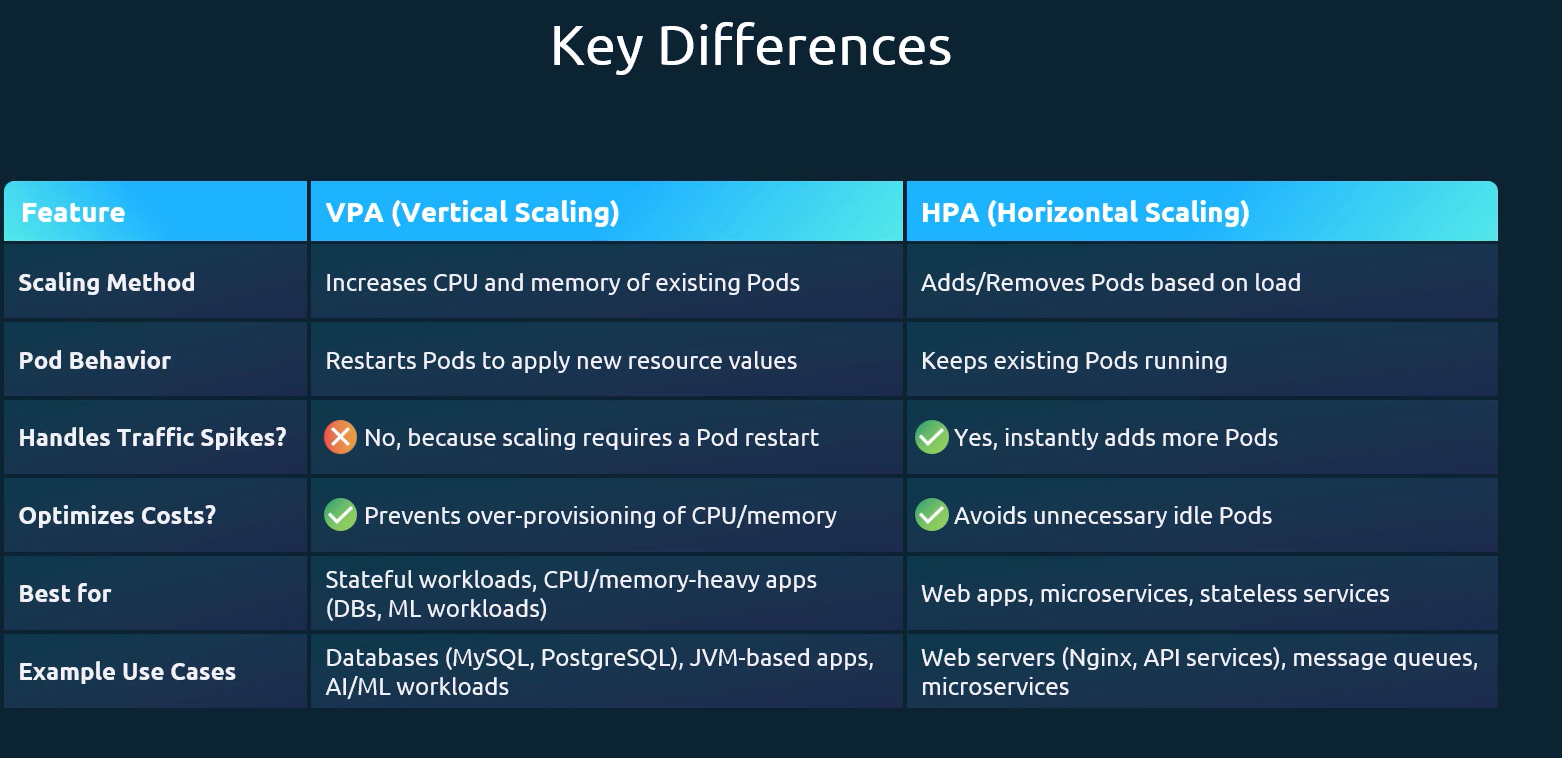

In the latest versions of Kubernetes (v1.30 and v1.35), autoscaling is a multi-dimensional system designed to ensure applications have exactly the resources they need. To understand this for your interview, think of it as a choice between **scaling out** (adding more workers) and **scaling up** (giving each worker more power).

### 1. Horizontal Pod Autoscaling (HPA)
HPA aims to automatically update a workload resource (like a Deployment or StatefulSet) to match demand by **deploying more Pods**.

*   **How it Works:** The HPA controller periodically (every 15 seconds by default) queries metrics from the **Metrics Server**. It calculates the required number of replicas using this ratio: 
    *   `desiredReplicas = ceil[currentReplicas * (currentMetricValue / desiredMetricValue)]`.
*   **Latest v1.30 Update:** It now supports **Container Resource Metrics** (stable). You can now scale based on the resource usage of individual containers (like just your main "application" container) while ignoring the noise from sidecars like loggers.
*   **Latest v1.35 Update:** The **Tolerance** field is now in beta. You can configure a specific threshold (e.g., 5%) for metric variations to prevent the autoscaler from "flapping" (scaling up and down rapidly) due to minor fluctuations.
*   **Best Use Case:** Stateless applications that can handle traffic being distributed across many identical copies.

### 2. Vertical Pod Autoscaling (VPA)
VPA, often called **"rightsizing,"** automatically adjusts the **resource requests and limits** (CPU and memory) of the Pods already running in your workload.

*   **How it Works:** VPA is a Custom Resource Definition (CRD) that must be installed separately. It uses three components:
    1.  **Recommender:** Analyzes historical usage and OOM (Out of Memory) events to suggest "Target," "Lower Bound," and "Upper Bound" values.
    2.  **Updater:** Evicts Pods that need different resources so they can be recreated with the new specs.
    3.  **Admission Controller:** A mutating webhook that intercepts Pod creation and injects the recommended resource values.
*   **Update Modes:** 
    *   **InPlaceOrRecreate:** A newer mode that tries to update resources **without restarting the Pod** if the cluster supports it, falling back to a restart only if necessary.
    *   **Off:** Only provides recommendations (useful for initial discovery of an app's needs).
*   **Best Use Case:** Stateful applications (like databases) that are hard to scale horizontally, or for optimizing the cost/efficiency of any application by finding its true resource footprint.

### Key Comparison Table

| Feature | Horizontal (HPA) | Vertical (VPA) |
| :--- | :--- | :--- |
| **Action** | Changes the **number** of Pods. | Changes the **size** of Pods. |
| **Primary Metric** | Usually CPU/Memory utilization or QPS. | Historical usage trends and OOM events. |
| **Disruption** | Generally nondisruptive (adds/removes replicas). | Can be disruptive (often requires Pod restarts). |
| **API Status** | Core Kubernetes API (`autoscaling/v2`). | Custom Resource (CRD). |
| **Main Benefit** | Handles sudden spikes in traffic. | Prevents resource waste and "OOMKills". |

### Interview Pro-Tip: "The Coexistence Problem"
If an interviewer asks if you can use both together, warn them about **"double scaling."** If HPA and VPA are both set to scale based on CPU, they might conflict—VPA might try to increase CPU per Pod while HPA is trying to add more Pods. This leads to unpredictable behavior. It is generally best to let HPA handle **load-based scaling** (e.g., CPU/QPS) and let VPA handle **resource optimization** over time using different metrics.

----
----

While it is true that both can scale down to save resources, they do so in fundamentally different ways. The reason **Vertical Pod Autoscaling (VPA)** is considered superior for **preventing resource waste** and **OOMKills** (Out-Of-Memory kills) lies in its ability to "right-size" the individual Pod rather than just changing the number of Pods.

### 1. Preventing Resource Waste: "Scaling Count" vs. "Scaling Size"
*   **HPA (Scaling Count):** HPA removes entire Pods when load decreases. However, if your remaining Pods are still configured with **oversized resource requests** (e.g., a Pod requests 2GB of RAM but only uses 200MB), that "gap" is still wasted capacity on your node.
*   **VPA (Scaling Size):** VPA acts as an **"autopilot" or "rightsizing" tool**. If a Pod is using significantly less than what it requested, VPA adjusts those requests **back down to match actual usage**. This ensures that the Pod only "reserves" what it actually needs, leaving more room on the node for other workloads.

### 2. Preventing OOMKills: Reacting to the Limit
*   **HPA (The Metric Problem):** HPA typically scales based on a percentage of the **requested** resource (e.g., "scale up when CPU hits 50% of the request"). It often struggles with memory because memory usage is not always **linearly correlated** with the number of Pods. If a single process requires 1GB of RAM to complete a task but is limited to 500MB, adding more Pod replicas via HPA will not help; each new replica will simply hit the same limit and crash.
*   **VPA (The Event Observer):** VPA specifically monitors **real-time events such as OOM conditions** and historical resource incidents. If a Pod is OOMKilled, the **VPA Recommender** analyzes that failure and calculates a new, higher **"upper bound"** and **"target recommendation"** to ensure the Pod has enough "headroom" to survive next time.

### 3. Why HPA is "Not Good" for Memory Tuning
The sources highlight a critical limitation of HPA regarding memory:
*   **Incompressible Resource:** Unlike CPU, which can be throttled, memory is **incompressible**; if a process exceeds its limit, it is killed.
*   **No Linear Decrease:** For HPA to work, increasing the number of Pods must result in a **linear decrease** in the average metric value. For many apps, starting more Pods does not force the original Pods to release their allocated memory. If the memory isn't released, HPA will keep adding Pods in a futile attempt to lower the average until it hits its maximum limit.

### Summary Comparison
| Goal | Horizontal (HPA) | Vertical (VPA) |
| :--- | :--- | :--- |
| **Waste Prevention** | Removes extra Pods, but individual Pods may still be "fat" and wasteful. | Shrinks the individual Pod's requests to match its actual footprint ("rightsizing"). |
| **OOMKill Prevention** | Adds more Pods, which may not stop a single "undersized" Pod from crashing. | Learns from OOM events and increases memory requests/limits so the Pod has enough room. |

In short, **HPA handles the quantity of work** (traffic spikes), while **VPA handles the quality of the configuration** (resource accuracy). Using them together requires caution to avoid "double scaling" where both try to react to the same metric simultaneously.

----
----
----


The **"double scaling" problem** occurs because the Horizontal Pod Autoscaler (HPA) and Vertical Pod Autoscaler (VPA) are currently **not aware of each other**. If both are configured to react to the same resource metrics (like CPU or Memory), they may both attempt to scale at the same time, leading to unpredictable and redundant resource allocation.

Here are the thumb rules to avoid these conflicts:

### 1. Never scale both on the same resource metric
The most important rule is to ensure that HPA and VPA are **not looking at the same signal** to make decisions. 
*   **The Conflict:** If HPA is set to scale out when CPU utilization hits 50% and VPA is also monitoring CPU to "rightsize" the pod, HPA might add more pods while VPA simultaneously increases the CPU request for those pods.
*   **The Solution:** If you must use both, let **VPA manage the resource requests** (CPU/Memory) and let **HPA scale based on custom or external metrics**, such as Queries-Per-Second (QPS) or message queue depth.

### 2. Use VPA in "Off" mode for observation
If you are unsure of the correct resource requests for an application that is already using HPA, use **VPA with `updateMode: "Off"`**. 
*   In this mode, the VPA **recommender** will still analyze historical resource usage and provide a "Target recommendation," but it **will not actually change the pods**.
*   This allows you to manually "rightsize" your HPA-controlled deployment based on real-world usage data without risking a scaling clash.

### 3. Use HPA for load and VPA for rightsizing
A common architectural pattern is to use **VPA to find the optimal "base size"** of a pod and **HPA to handle sudden spikes** in traffic.
*   VPA is better suited for **stateful services** or identifying long-term resource needs based on historical consumption patterns.
*   HPA is best for **stateless services** that need to adapt rapidly to shifting resource needs by adding or removing replicas.

### 4. Define Resource Policies to set boundaries
To prevent VPA from growing a pod to a size that interferes with HPA’s logic or cluster capacity, use the **`resourcePolicy`** section in your VPA definition.
*   Use **`minAllowed` and `maxAllowed`** to set hard boundaries on how much VPA can adjust a container’s resources.
*   This ensures that even if VPA detects a high resource need, it won't scale a pod so large that it makes the cluster's horizontal scaling (HPA) inefficient or impossible due to node capacity limits.

### 5. Prioritize Horizontal Scaling for Stateless Apps
Because horizontal scaling is **less disruptive** (it doesn't require restarting pods to apply changes), it is the **preferred form of scaling** for most Kubernetes applications. VPA traditionally requires **evicting and recreating pods** to update resource requests, which can lead to temporary service disruptions. Use VPA only when the application cannot be scaled horizontally or when its resource footprint is highly unpredictable.

---
---
---


To understand autoscaling in modern Kubernetes, you must distinguish between **Horizontal Pod Autoscaling (HPA)**, which adjusts the number of replicas, and **Vertical Pod Autoscaling (VPA)**, which adjusts the resource "size" (CPU/Memory) of individual pods.

### 1. Horizontal Pod Autoscaler (HPA) Modes & Behaviors
HPA operates by increasing or decreasing the **number of Pods** in a workload (like a Deployment or StatefulSet) to match demand. In the latest versions (`autoscaling/v2`), HPA is defined by the **metrics** it tracks and the **scaling behaviors** you configure.

#### Key "Modes" (Metric Sources)
*   **Resource:** Scales based on CPU or Memory utilization of all containers in a pod.
*   **ContainerResource:** Scales based on a specific container within the pod, allowing you to ignore "noisy" sidecars (Stable in v1.30).
*   **Custom/Object:** Scales based on metrics not built into Kubernetes (like Queries-Per-Second or Ingress latency).

#### Sample HPA Manifest (CPU Utilization)
This example keeps a Deployment's CPU usage at 50% across 1 to 5 replicas.

```yaml
apiVersion: autoscaling/v2
kind: HorizontalPodAutoscaler
metadata:
  name: random-generator-hpa
spec:
  scaleTargetRef:
    apiVersion: apps/v1
    kind: Deployment
    name: random-generator
  minReplicas: 1
  maxReplicas: 5
  metrics:
  - type: Resource
    resource:
      name: cpu
      target:
        type: Utilization
        averageUtilization: 50
```

---

### 2. Vertical Pod Autoscaler (VPA) Update Modes
VPA is a **Custom Resource Definition (CRD)** that must be installed separately. It uses a **Recommender** to analyze historical usage and an **Updater** to apply changes. VPA is defined by four primary **Update Modes**:

*   **`Off`:** VPA only generates recommendations in the `.status` field. It **never** changes your pods automatically.
*   **`Initial`:** VPA assigns recommended resources **only when the pod is first created**. It will not update pods that are already running.
*   **`Recreate`:** The most common active mode. It **evicts** running pods that need rightsizing so they can be recreated with the new CPU/Memory specs.
*   **`InPlaceOrRecreate`:** Attempts to update resources **without restarting the pod** (requires cluster support for in-place resizing). If that fails, it falls back to eviction.
*   *Note: `Auto` mode is deprecated and currently behaves exactly like `Recreate`.*

#### Sample VPA Manifest (Recreate Mode with Boundaries)
This example uses `resourcePolicy` to set hard limits on how small or large VPA can scale the container.

```yaml
apiVersion: autoscaling.k8s.io/v1
kind: VerticalPodAutoscaler
metadata:
  name: my-app-vpa
spec:
  targetRef:
    apiVersion: "apps/v1"
    kind: Deployment
    name: my-app
  updatePolicy:
    updateMode: "Recreate"  # Actively evicts pods to apply changes
  resourcePolicy:
    containerPolicies:
    - containerName: "application"
      minAllowed:
        cpu: 100m
        memory: 128Mi
      maxAllowed:
        cpu: 2
        memory: 2Gi
      controlledValues: RequestsAndLimits # Controls both requests and limits
```

### Comparison Summary
| Feature | HPA | VPA |
| :--- | :--- | :--- |
| **Primary Action** | Changes **Pod count**. | Changes **Pod size**. |
| **API Type** | Core Kubernetes API (`autoscaling/v2`). | Custom Resource (CRD). |
| **Best For** | Handling sudden traffic spikes. | Rightsizing and preventing OOMKills. |
| **Disruption** | Nondisruptive (adds/removes replicas). | Can be disruptive (requires pod restarts in `Recreate` mode). |

----
----
----
Cluster Autoscaler
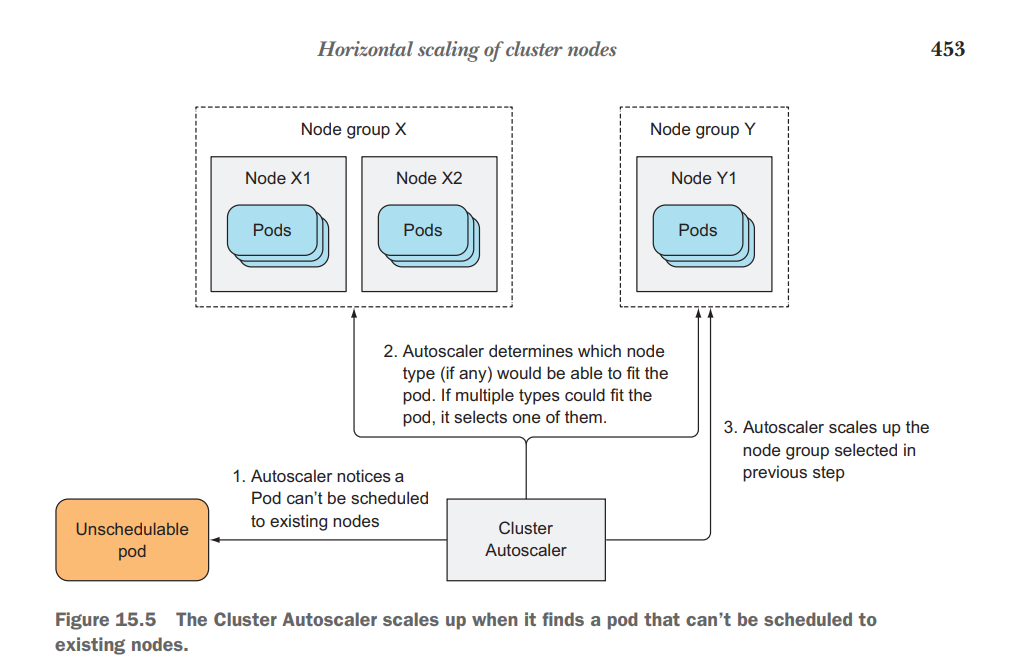